# Word embeddings approach using LSA/LSI

Though the fuzzy similarity approach (based on Levenshtein distance)
seem to work on several cases in the USP data,
most of the correct results should be *almost* normalized
in order to have a small edit distance.
The fuzzy approach will neither fill empty fields,
nor fix huge mistakes in what had been filled.
To do that, we were looking at the remaining fields
using a graph approach.
The adjacency matrix entries should be normalized
using both the row and column frequencies,
but that won't fix entries
whose contents had been "swapped" among the columns.

The goal here is to use a topic modeling approach,
using a word embedding matrix
instead of using the CSV columns
(i.e., each word is a feature, no matter where it came from).
This is a Latent Semantic Analysis (LSA) from the TF-IDF matrix,
ending with classification models
to fill the empty fields.

*PS: LSI stands for Latent Semantic Indexing.*

In [1]:
import random, re, warnings

Install the following packages with:

```
pip install gensim matplotlib numpy pandas scikit-learn unidecode
```

In [2]:
from gensim import corpora, matutils, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster, ensemble, metrics, model_selection, neighbors
from unidecode import unidecode

In [3]:
random.seed(42)
np.random.seed(123)
pd.options.display.max_colwidth = 400 # Avoid "..." in large strings
pd.options.display.max_rows = 120     # Avoid "..." in the table representation of lengthy dataframes
%matplotlib inline

In [4]:
warnings.filterwarnings(
    action="ignore",
    message="(?:.* and F-score are ill-defined|F-score is ill-defined.*)",
    category=metrics.classification.UndefinedMetricWarning,
)

## Pre-normalized word list

We'll get only the words in the fields that aren't IDs/numbers/symbols,
and pre-normalize them by removing accents and symbols,
and by lowercasing everything.

It's the same CSV from Clea's output analyzed in the previous experiments.

In [5]:
TEXT_ONLY_REGEX = re.compile("[^a-zA-Z ]")

In [6]:
def pre_normalize(name):
    return TEXT_ONLY_REGEX.sub("", unidecode(name).lower())

In [7]:
dataset = pd.read_csv("inner_join_2018-06-04.csv",
                      dtype=str,
                      keep_default_na=False) \
            .drop_duplicates()

In [8]:
fields = [
    "addr_city",
    "addr_country",
    "addr_country_code",
    "addr_state",
    "aff_text",
    "article_title",
    "contrib_bio",
    "contrib_prefix",
    "contrib_name",
    "contrib_surname",
    "institution_orgdiv1",
    "institution_orgdiv2",
    "institution_orgname",
    "institution_orgname_rewritten",
    "institution_original",
    "institution_orgname_rewritten",
    "journal_title",
    "publisher_name",
]

In [9]:
word_lists = dataset[fields].T.apply(lambda row: pre_normalize(" ".join(row)).split())
word_lists.head()

0    [brazil, br, e, doutora, em, sociologia, pela, universidade, federal, do, rio, grande, do, sul, ufrgs, e, professora, do, programa, de, posgraduacao, em, ciencia, politica, e, do, programa, de, posgraduacao, em, politicas, publicas, desta, mesma, universidade, email, ligiamorimadeiragmailcom, universidade, federal, do, rio, grande, do, sul, universidade, federal, do, rio, grande, do, sul, ufrg...
1    [brazil, br, e, professor, do, departamento, de, sociologia, da, universidade, federal, do, rio, grande, do, sul, ufrgs, integrando, o, programa, de, posgraduacao, em, sociologia, e, o, programa, de, posgraduacao, em, desenvolvimento, rural, coordena, o, grupo, de, pesquisa, associativismo, contestacao, e, engajamento, gpace, wwwufrgsbrgpace, email, mksilvaufrgsbr, universidade, federal, do, r...
2    [brazil, br, e, professora, do, instituto, federal, sulriograndense, ifsul, campus, sapucaia, do, sul, doutoranda, no, programa, de, posgraduacao, em, sociologia, integra, o, gpace, ema

The $5$ word lists above regards to the first $5$ entries in the CSV.
Are we able to predict the empty fields from an embedding
created from the word lists?

At first, there are too many distinct words!
We should remove words that won't help us.

In [10]:
dictionary = corpora.Dictionary(word_lists)
len(dictionary) # "Raw" word count

102136

Let's remove:

* Words that appear in less than $3$ documents (rows of the CSV);
* Some cherry-picked stop words (mostly for Brazilian Portuguese);
* Words that has only a single character (`d`, `y`, `a`, `o`, etc.).

In [11]:
uncommon_words = [token for token, tid in dictionary.token2id.items() if dictionary.dfs[tid] <= 2]
stop_words = ["da", "de", "desta", "do", "em", "ii", "iii", "in", "mesma", "no", "pela", "pelos"]
single_char_words = [token for token in dictionary.token2id if len(token) == 1]

In [12]:
dictionary.filter_tokens(bad_ids=[dictionary.token2id[token]
                                  for token in uncommon_words + stop_words + single_char_words])
dictionary.compactify()
len(dictionary) # Word count after filtering

48712

More than half of the words had been removed.

## BoW and TF-IDF

The *bag of words* model for the entire corpus
and the TF-IDF are:

In [13]:
corpus = [dictionary.doc2bow(wlist) for wlist in word_lists]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Let's see what's going on for the first few words and documents.

In [14]:
num2plot = 400
csc_corpus = matutils.corpus2csc(corpus, num_terms=len(dictionary))
csc_tfidf = matutils.corpus2csc(corpus_tfidf, num_terms=len(dictionary))

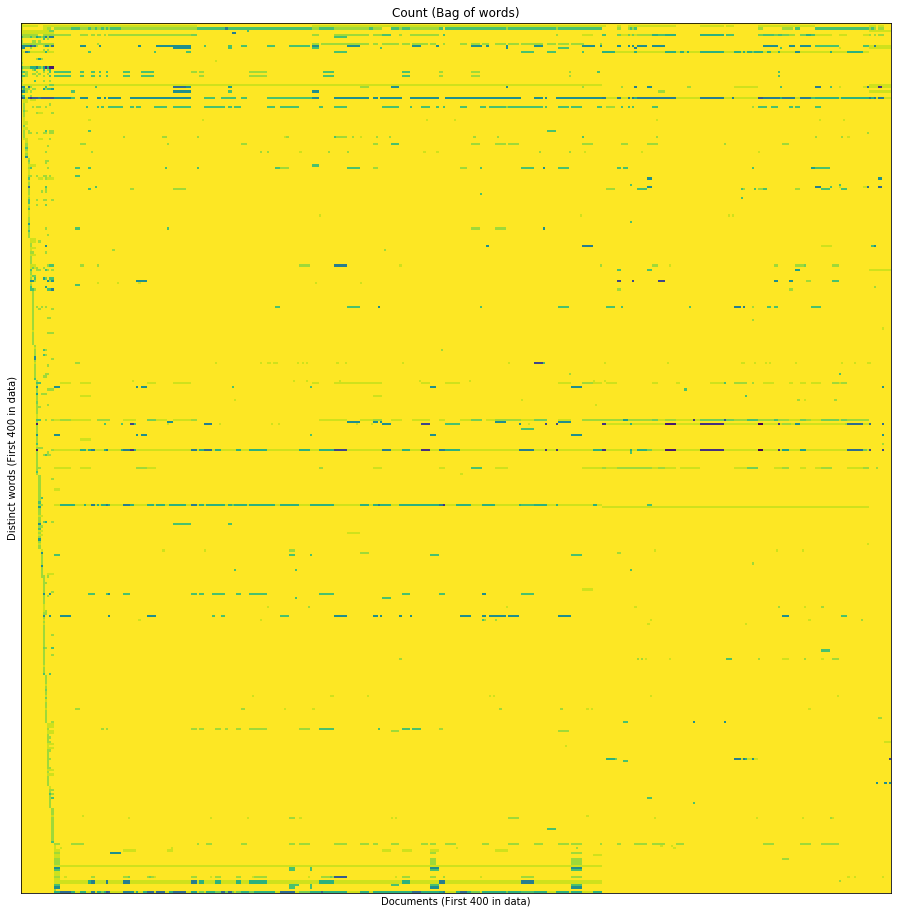

In [15]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="Count (Bag of words)",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

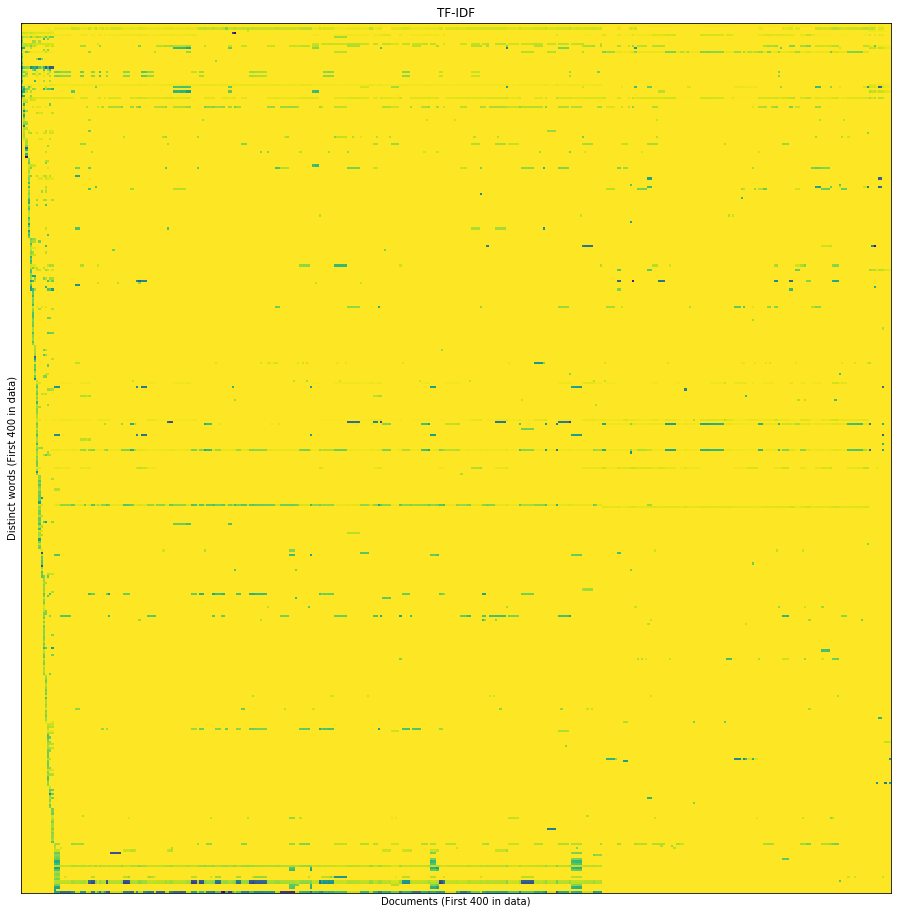

In [16]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf[:num2plot, :num2plot].todense(), cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents (First {num2plot} in data)",
       yticks=[], ylabel=f"Distinct words (First {num2plot} in data)");

Each row in these plots regards to a single word,
and each column regards to a single document
(an affiliation-contributor matching pair,
 from `<aff>` and `<contrib>` XML nodes).
The first plot has the raw count of words in each document
(each column is a *bag of words*).

The "line" with a quite negative slope at the left of both plots
shows the first time each word appeared in the documents,
as we're seeing the first indices in the dictionary.
The horizontal line at the bottom shows that there's a single word
that appears in several documents, but the lack of greenish elements
at its right shows it's quite informative:
a simple approach to a document classification could be querying
if that word appears in the document.

The distinction between the *Count/BoW* plot and the *TF-IDF* plot
is of a normalization nature.
TF-IDF means *Term Frequency (times) Inverse Document Frequency*,
that is:

$$
\operatorname{tfidf}(t, d, D) = \operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$

Where $t$ is a term, $d$ is a document and $D$ is the dictionary.
In the `gensim` implementation,
$\operatorname{tf}$ is the raw term count in the document,
$\operatorname{idf}$ is the negative logarithm (base $2$) of the proportion of
documents that have the given term,
and the overall result (i.e., the vector of TF-IDF for a given document)
is normalized/scaled to unit norm/length.

Let's try to see this result by plotting the $400$ words
and $400$ documents whose TF-IDF entries have the largest variances
(row-wise for the terms/words, column-wise for the documents).

In [17]:
var_docs = (
    csc_tfidf.power(2).mean(axis=0) - csc_tfidf.mean(axis=0).A ** 2
).A.ravel()
var_terms = (
    csc_tfidf.power(2).mean(axis=1) - csc_tfidf.mean(axis=1).A ** 2
).A.ravel()

maxvar_docs_idx = np.argsort(var_docs)[-num2plot:]
maxvar_terms_idx = np.argsort(var_terms)[-num2plot:]

csc_corpus_block = csc_corpus[maxvar_terms_idx].T \
                             [maxvar_docs_idx].T.todense()
csc_tfidf_block = csc_tfidf[maxvar_terms_idx].T \
                           [maxvar_docs_idx].T.todense()

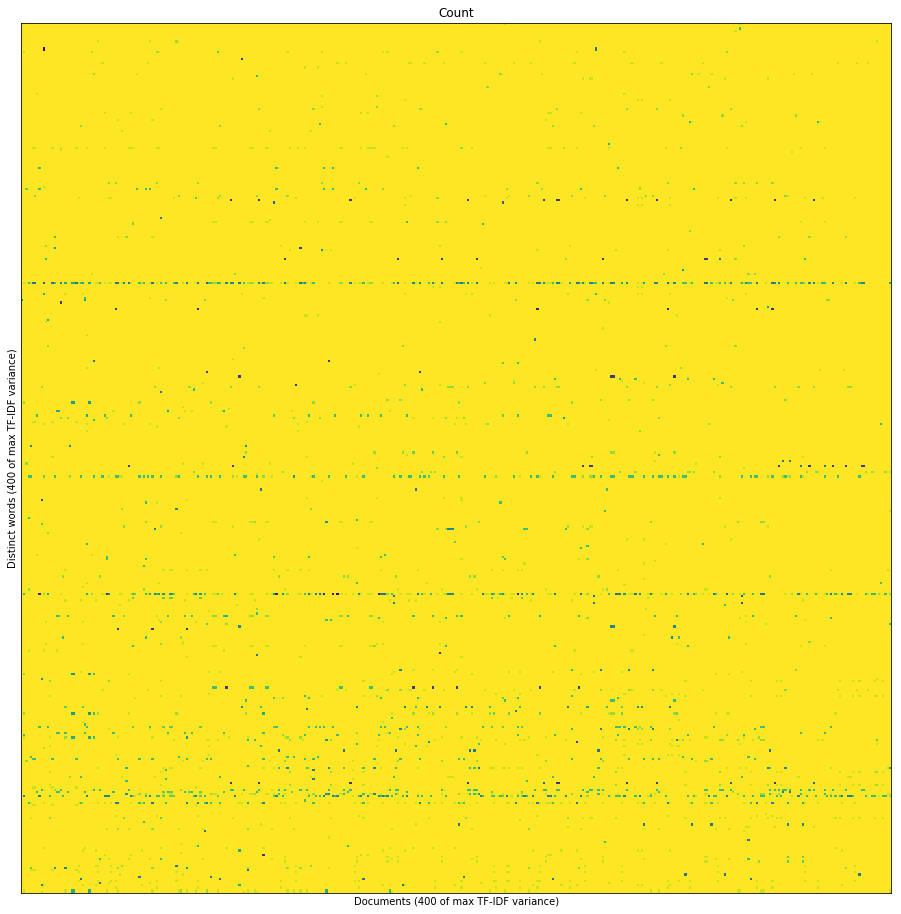

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_corpus_block, cmap=plt.cm.viridis_r)
ax.set(title="Count",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

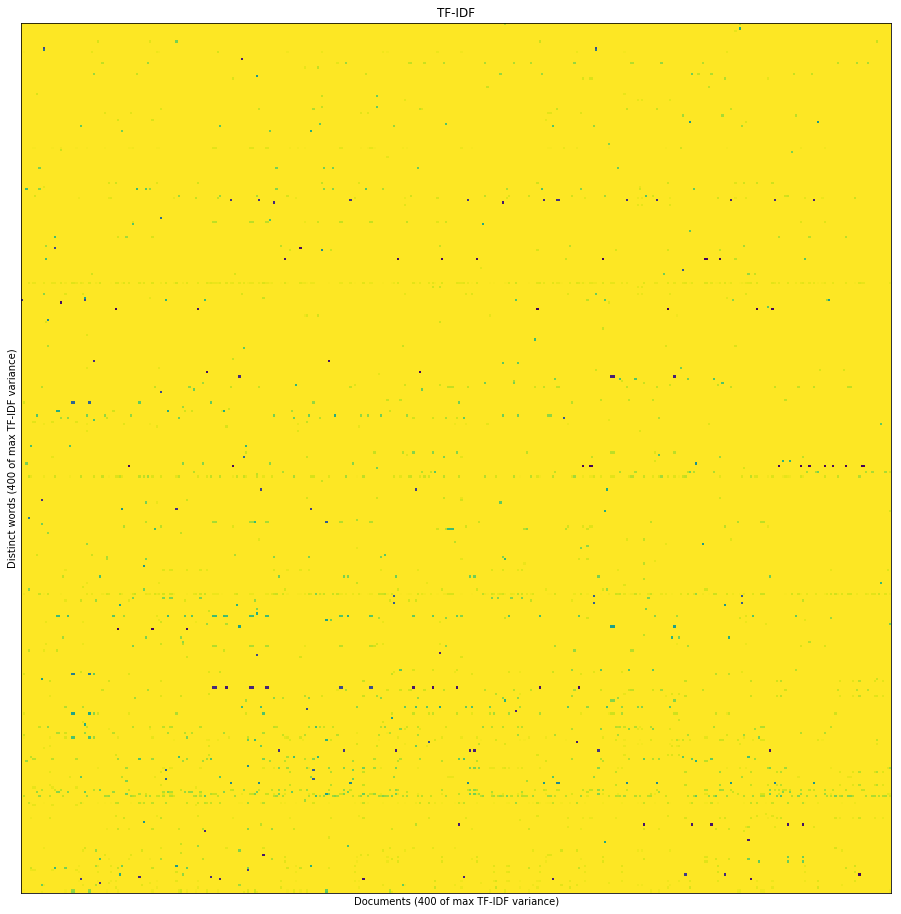

In [19]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(csc_tfidf_block, cmap=plt.cm.viridis_r)
ax.set(title="TF-IDF",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

Though these last images represent the same data (terms and documents),
the TF-IDF is more yellowish / cleaner.
A lot of words with a high value in the BoW model
aren't informative for document discrimination.

## LSI - Latent Semantic Indexing

The randomness suggests there are some information we can directly use to create classifiers.

The goal here is to remove redundancy from that huge matrix by lowering its rank.
The whole idea is to minimize the Frobenius norm
(the *truncated SVD* approach for dimensionality reduction).
Given our TF-IDF matrix $\mathbf{X}$,
where each column is a document and each row is a term,
we can perform SVD:

$$
\mathbf{X} = \mathbf{U} \cdot \mathbf{\Sigma} \cdot \mathbf{V}^T
$$

As we know, its transpose is:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T
& \displaystyle = & \displaystyle
  \left( \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T \right)^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\end{array}
$$

Where $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices
(i.e., their transpose are their inverse).
Actually their columns are the eigenvectors of
$\mathbf{X} \mathbf{X}^T$ and $\mathbf{X}^T \mathbf{X}$ since:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X} \mathbf{X}^T
& \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{-1}
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma} \mathbf{\Sigma}^T \mathbf{U}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{U} \mathbf{\Sigma}_U^2 \mathbf{U}^T
\end{array}
$$

And:

$$
\begin{array}{rcl} \displaystyle
\mathbf{X}^T \mathbf{X}
& \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^T
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{U}^{-1}
  \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}^T \mathbf{\Sigma} \mathbf{V}^T
\\ & \displaystyle = & \displaystyle
  \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T
\end{array}
$$

Lowering the rank is just zeroing *the smallest singular values $\sigma_i$ in $\mathbf{\Sigma}$*.
That is, we perform SVD, replace the smallest singular values by zero, and resynthesize the matrix with:

$$
\mathbf{X}_k = \mathbf{U} \cdot \mathbf{\Sigma}_k \cdot \mathbf{V}^T
$$

The magnitude of the matrix measured by its Frobenius norm is also lowered,
but in some sense the changes are the smaller they could be, since
the Frobenius norm of $\mathbf{X}$ is:

$$
||\mathbf{X}||_F = \sqrt{\sum_{i=1}^n \sum_{j=1}^m x_{ij}^2}
                 = \sqrt{\operatorname{tr} \left( \mathbf{X}^T \mathbf{X} \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V} \mathbf{\Sigma}_V^2 \mathbf{V}^T \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{V}^T \mathbf{V} \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\operatorname{tr} \left( \mathbf{\Sigma}_V^2 \right) }
                 = \sqrt{\sum \sigma_i^2 }
$$

(Remind the trace of a product is invariant under cyclic permutation)

Actually, we don't need to fully resynthesize the matrix.
To apply the model directly from the SVD results
(i.e., to find a document representation in the word embedding space)
on a $\mathbf{d}$ vector having a single document TF-IDF,
we need to perform $\pmb{\Sigma}_k^{-1} \mathbf{U}^T \mathbf{d}$,
since that's what we're doing with the documents from $\mathbf{X}_k$.
Explicitly,
$\mathbf{X}_k = [\mathbf{d}_1 \mathbf{d}_2 \cdots \mathbf{d}_n]$,
a matrix where each column belongs to a single distinct document,
and:

$$
\mathbf{U}^T \cdot [\mathbf{d}_1 \mathbf{d}_2 \cdots \mathbf{d}_n] = \mathbf{\Sigma}_k \cdot \mathbf{V}^T
$$

The LSI model from `gensim` doesn't apply the scaling factor
$\pmb{\Sigma}_k^{-1}$ (a diagonal matrix
with the inverse of the largest $k$ singular values
and zeros for the remaining dimensions).

### LSI in `gensim`

Let's perform LSA through the `gensim` LSI model:

In [20]:
num_topics = 200 # "k" in the above explanation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]
matrix_lsi = matutils.corpus2dense(corpus_lsi, num_terms=lsi.num_topics)

This matrix has a vector for each entry in our corpus,
represented in a word embedding space.

In [21]:
matrix_lsi.shape

(200, 89451)

It's a more compact representation for the "randomness" we've seen in TF-IDF,
*blurring* the TF-IDF results (by lowering the TF-IDF matrix rank).

In [22]:
lsi_block = lsi.projection.u[maxvar_terms_idx, :] \
          @ np.diag(lsi.projection.s) \
          @ (matrix_lsi[:, maxvar_docs_idx])

This is what the TF-IDF selection became, after lowering the matrix rank:

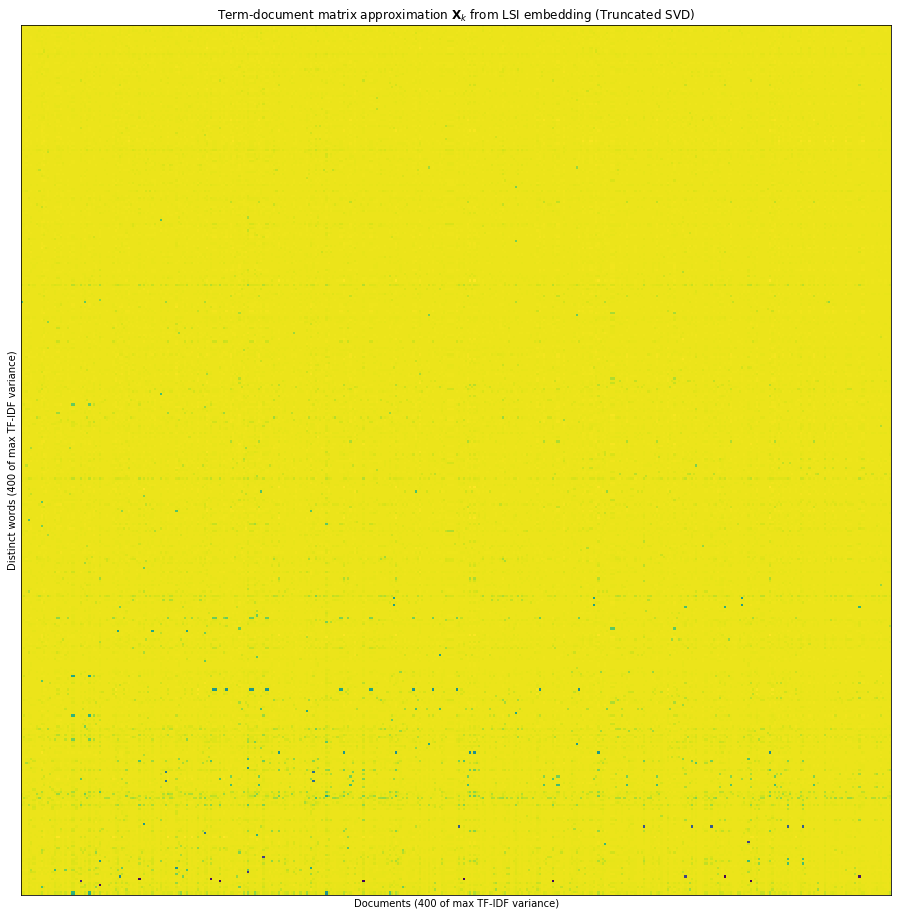

In [23]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(lsi_block, cmap=plt.cm.viridis_r)
ax.set(title=r"Term-document matrix approximation $\mathbf{X}_k$ from LSI embedding (Truncated SVD)",
       xticks=[], xlabel=f"Documents ({num2plot} of max TF-IDF variance)",
       yticks=[], ylabel=f"Distinct words ({num2plot} of max TF-IDF variance)");

### Word embedding space of topics and the weight of singular values

Given a document $\mathbf{d}$,
there are two word embeddings we can use
coming from LSA.
We'll call them as:

* *Unscaled LSI* low-rank/topic/embedding representation:
  $\mathbf{U}^T \mathbf{d}$
* *LSI* low-rank/topic/embedding representation:
  $\pmb{\Sigma}_k^{-1} \mathbf{U}^T \mathbf{d}$

Despite the LSI name, we won't be "indexing" documents/queries
using this embedding representation.

The raw representation of LSI
without the $\pmb{\Sigma}_k^{-1}$ scaling factor, is:

In [24]:
mlsi_min, mlsi_max = matrix_lsi.min(), matrix_lsi.max()
mlsivar_argsort = np.argsort(matrix_lsi.var(axis=0))

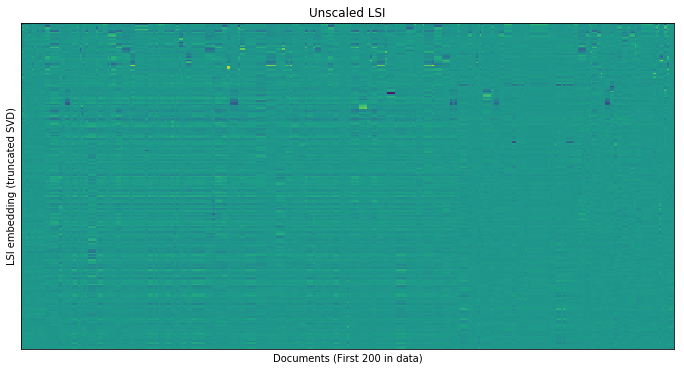

In [25]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(matrix_lsi[:, :400],
          cmap=plt.cm.viridis_r, vmin=mlsi_min, vmax=mlsi_max)
ax.set(title="Unscaled LSI",
       xticks=[], xlabel=f"Documents (First {num_topics} in data)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

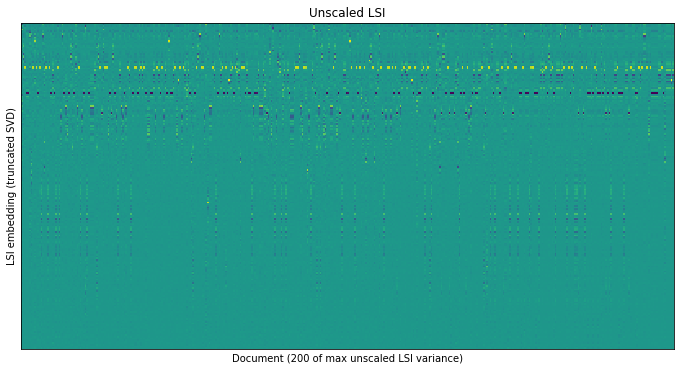

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(matrix_lsi[:, mlsivar_argsort[-400:]],
          cmap=plt.cm.viridis_r, vmin=mlsi_min, vmax=mlsi_max)
ax.set(title="Unscaled LSI",
       xticks=[], xlabel=f"Document ({num_topics} of max unscaled LSI variance)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

We can apply the scaling factor to "normalize" this matrix,
dividing it by the singular values stored in `lsi.projection.s`.
Let's perform that and compare the results.

In [27]:
smatrix_lsi = matrix_lsi / lsi.projection.s[:, None]
sml_min, sml_max = smatrix_lsi.min(), smatrix_lsi.max()
smlsivar_argsort = np.argsort(smatrix_lsi.var(axis=0))

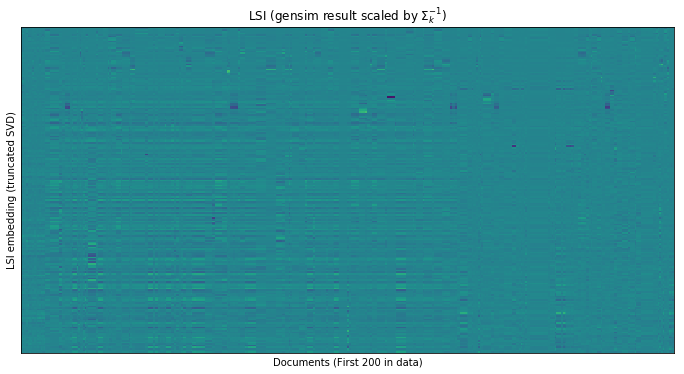

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(smatrix_lsi[:, :400],
          cmap=plt.cm.viridis_r, vmin=sml_min, vmax=sml_max)
ax.set(title=r"LSI (gensim result scaled by $\Sigma_k^{-1})$",
       xticks=[], xlabel=f"Documents (First {num_topics} in data)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

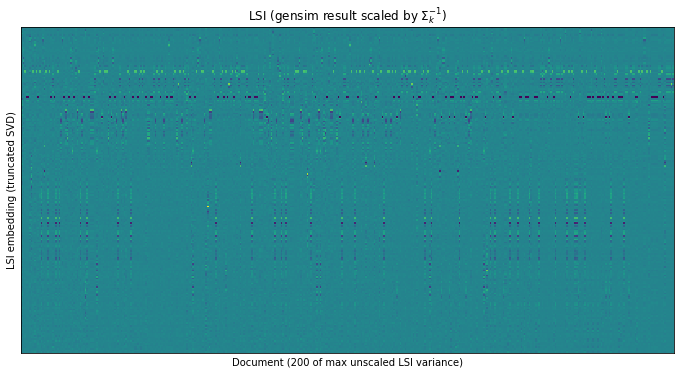

In [29]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(smatrix_lsi[:, mlsivar_argsort[-400:]],
          cmap=plt.cm.viridis_r, vmin=sml_min, vmax=sml_max)
ax.set(title=r"LSI (gensim result scaled by $\Sigma_k^{-1})$",
       xticks=[], xlabel=f"Document ({num_topics} of max unscaled LSI variance)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

These are almost the same,
but the entries with maximum variance aren't the same:

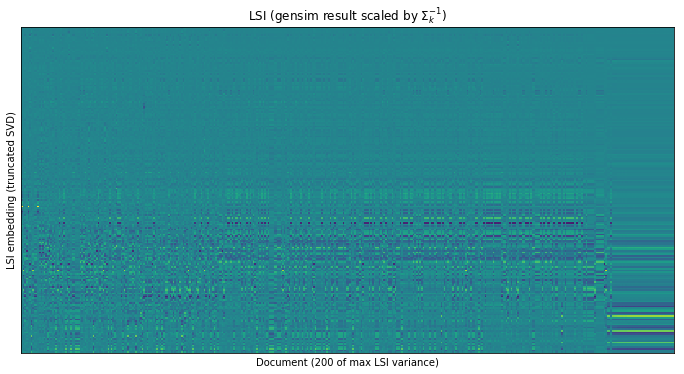

In [30]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(smatrix_lsi[:, smlsivar_argsort[-400:]],
          cmap=plt.cm.viridis_r, vmin=sml_min, vmax=sml_max)
ax.set(title=r"LSI (gensim result scaled by $\Sigma_k^{-1})$",
       xticks=[], xlabel=f"Document ({num_topics} of max LSI variance)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

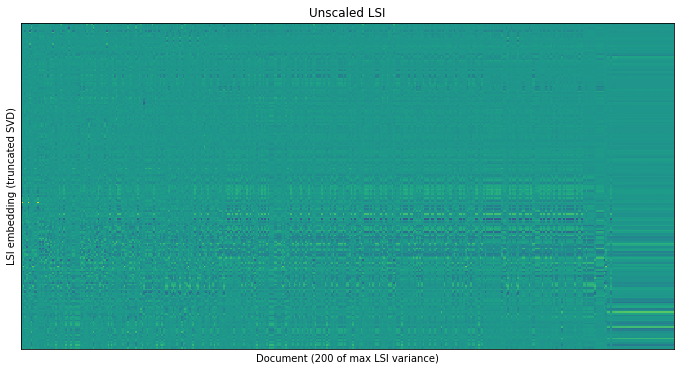

In [31]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.imshow(matrix_lsi[:, smlsivar_argsort[-400:]],
          cmap=plt.cm.viridis_r, vmin=mlsi_min, vmax=mlsi_max)
ax.set(title="Unscaled LSI",
       xticks=[], xlabel=f"Document ({num_topics} of max LSI variance)",
       yticks=[], ylabel="LSI embedding (truncated SVD)");

The following statistics regarding the scaling factor
show we're "scaling" it from $1$ to $\approx 8.15$
(besides a common scale factor of $\approx 0.02$):

In [32]:
lsi_scaling_factors = pd.Series(1 / lsi.projection.s).describe()
pd.DataFrame([
    lsi_scaling_factors.rename("factor"),
    (lsi_scaling_factors / lsi_scaling_factors["min"]).rename("proportion of min")
]).drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
factor,0.102116,0.038588,0.020623,0.072438,0.103902,0.134541,0.168672
proportion of min,4.951455,1.871083,1.000000,3.512423,5.038088,6.523720,8.178689


Okay, but how can we use that matrix for clustering/classification?

## K-Means clustering of the LSI matrix data

We can try to find clusters with something like K-Means.
That's simple, yet it would be difficult
for us to find some meaning to label the clusters.

In [33]:
%%time
kmeans_model = cluster.KMeans(5, random_state=1234).fit(matrix_lsi.T)
classes = kmeans_model.predict(matrix_lsi.T)

CPU times: user 20.1 s, sys: 409 ms, total: 20.5 s
Wall time: 10.1 s


In [34]:
dataset.assign(**{"class": classes}).head().T

,0,1,2,3,4
addr_city,,,,,
addr_country,Brazil,Brazil,Brazil,Brazil,Brazil
addr_country_code,BR,BR,BR,BR,BR
addr_postal_code,,,,,
addr_state,,,,,
aff_email,ligiamorimadeira@gmail.com,mksilva@ufrgs.br,bianca.or@gmail.com,mrviegas@gmail.com,cardososampaio@gmail.com
aff_id,aff1,aff1,aff2,aff1,aff1
aff_text,* É doutora em Sociologia pela Universidade Federal do Rio Grande do Sul (UFRGS) e professora do Programa de Pós-Graduação em Ciência Política e do Programa de Pós-Graduação em Políticas Públicas desta mesma universidade. E-mail: <ligiamorimadeira@gmail.com>. Universidade Federal do Rio Grande do Sul Universidade Federal do Rio Grande do Sul (UFRGS) Brazil ligiamorimadeira@gmail.com,"* É professor do Departamento de Sociologia da Universidade Federal do Rio Grande do Sul (UFRGS), integrando o Programa de Pós-Graduação em Sociologia e o Programa de Pós-Graduação em Desenvolvimento Rural. Coordena o Grupo de Pesquisa Associativismo, Contestação e Engajamento (GPACE) - <www.ufrgs.br/gpace>. E-mail: <mksilva@ufrgs.br>. Universidade Federal do Rio Grande do Sul Universidade Fed...","** É professora do Instituto Federal Sul-rio-grandense (IFSUL), campus Sapucaia do Sul. Doutoranda no Programa de Pós-Graduação em Sociologia, integra o GPACE. E-mail: <bianca.or@gmail.com>. Instituto Federal Sul-rio-grandense Instituto Federal Sul-rio-grandense (IFSUL) Brazil bianca.or@gmail.com","* É sociólogo, mestre em Sociologia e Antropologia e doutor em Planejamento Urbano e Regional pela Universidade Federal do Rio de Janeiro (UFRJ). Atualmente é pesquisador da Fundação Instituto de Pesca do Estado do Rio de Janeiro (Fiperj), professor do Centro Universitário de Volta Redonda (Unifoa) e pesquisador vinculado ao Laboratório Estado, Trabalho, Território e Natureza do Instituto de P...",* É professor de Ciência Política na Universidade Federal do Paraná (UFPR). Doutor em Comunicação e Cultura Contemporâneas pela Universidade Federal da Bahia (UFBA). Pesquisador-associado do Centro de Estudos Avançados em Democracia Digital (CEADD) da UFBA e do Centro de Estudos Internacional do Governo (Cegov) da Universidade Federal do Rio Grande do Sul (UFRGS). E-mail: <cardososampaio@gmail...
article_doi,10.1590/0103-335220162102,10.1590/0103-335220162106,10.1590/0103-335220162106,10.1590/0103-335220162101,10.1590/0103-335220162108
article_publisher_id,,,,,


The class of these few examples seem to have to do
with the institution name or `institution_original`,
as the second and third entry shown belongs to the same article
but each affiliation-contributor entry has a distinct class.
It's hard to label it that way with just $5$ classes.
Perhaps a supervised learning approach would yield better results.

## Predicting the country with supervised learning - Train/Test split

We need to split our data in order to evaluate the results.
That assumes the inputs are mostly correct,
a quite reassuring assumption
(we couldn't do much if that's not true).
The input data should be split in $3$:
a *training* set, a *testing* set, and a *unknown* set.
Predictions on the latter should be evaluated manually.

However, we should re-create an LSI without
the text from the column we're trying to predict.
The following function helps us on that:

In [35]:
def create_dict_with_lsi_model(dataset, fields, num_topics, bad_tokens):
    word_lists = dataset[fields].T.apply(lambda row: pre_normalize(" ".join(row)).split())
    dictionary = corpora.Dictionary(word_lists)
    dictionary.filter_tokens(bad_ids=[dictionary.token2id[token]
                                      for token in uncommon_words + stop_words + single_char_words
                                      if token in dictionary.token2id])
    dictionary.compactify()
    corpus = [dictionary.doc2bow(wlist) for wlist in word_lists]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
    corpus_lsi = lsi[corpus_tfidf]
    matrix_lsi = matutils.corpus2dense(corpus_lsi, num_terms=lsi.num_topics)
    return locals().copy() # Shallow

This is a quite slow command that does almost everything we did,
but without the contents from the `addr_country` and `addr_country_code` columns,
the ones we wish to predict from the remaining data.

In [36]:
%%time
y_fields = ["addr_country_code", "addr_country"]
country_dict = create_dict_with_lsi_model(
    dataset=dataset,
    fields=[f for f in fields if f not in y_fields],
    num_topics=num_topics,
    bad_tokens=uncommon_words + stop_words + single_char_words,
)

CPU times: user 2min 46s, sys: 3.91 s, total: 2min 50s
Wall time: 1min 32s


For now, we want to find the country code,
which should be simpler and more meaningful than the country name
when it comes to evaluate the classification results,
due to the lack of input normalization.
Given that, we can split our data in the $3$ parts,
as previously described.

In [37]:
y_field = y_fields[0]
df_lsi = pd.DataFrame(country_dict["matrix_lsi"].T
                      / country_dict["lsi"].projection.s[None, :],
                      index=dataset.index)
df_lsi_filled_selector = dataset[y_field] != ""

X_unk = df_lsi[~df_lsi_filled_selector]

X = df_lsi[df_lsi_filled_selector]
y = dataset[df_lsi_filled_selector][y_field]

y_counts = y.value_counts()
y_strata = y.replace(y_counts[y_counts == 1].index, "")

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y,
                                     test_size=.3,
                                     random_state=1234,
                                     stratify=y_strata)

## Classification of the unscaled LSI to fill the country code

As our data is quite unbalanced,
naive models could easily be biased towards the most common country code,
which has more than $83.5\%$ of the input data:

In [38]:
y_train_counts = y_train.value_counts()
y_train_counts["BR"] / y_train_counts.sum()

0.8356959034721343

### k-NN

The k-NN model with $k \le 7$ should be ok with that unbalanced input,
"neglecting" any huge cluster sets that might exist
far away from the input document to be classified.
With $k > 1$, it would "neglecting" any single spurious input as well.
That is, we're going to use the matrix for a distance approach.

In [39]:
%%time
knn_models = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(),
    param_grid={"n_neighbors": [1, 3, 5, 7]},
    cv=model_selection.StratifiedKFold(n_splits=3, 
                                       shuffle=True,
                                       random_state=209),
    return_train_score=True,
    scoring="f1_micro",
    n_jobs=4,
).fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 1.19 s, sys: 196 ms, total: 1.39 s
Wall time: 32min 34s


As it seems, a nearest neighbor classifier (i.e., k-NN with $k = 1$)
is the best model for this data.

In [40]:
knn_model = knn_models.best_estimator_
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [41]:
knn_models.cv_results_

{'mean_fit_time': array([0.86701584, 0.82305026, 0.76688711, 0.7074097 ]),
 'std_fit_time': array([0.02652484, 0.01805497, 0.06084585, 0.00846284]),
 'mean_score_time': array([142.13998405, 229.52160899, 262.22590574, 267.12305466]),
 'std_score_time': array([0.66321982, 8.07492357, 2.83763123, 9.57691726]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 7],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 7}],
 'split0_test_score': array([0.95388304, 0.94479844, 0.94214876, 0.93886821]),
 'split1_test_score': array([0.95839929, 0.95048439, 0.94459571, 0.94206294]),
 'split2_test_score': array([0.95654105, 0.94956224, 0.9464535 , 0.94321787]),
 'mean_test_score': array([0.95627136, 0.94827659, 0.94439522, 0.94137873]),
 'std_test_score': array([0.00185471, 0.00249368, 0.00176335, 0.00184065]),
 'rank_test_score': array([1, 2, 3, 4], dtype=

In [42]:
%%time
y_pred = knn_model.predict(X_test)

CPU times: user 1min 50s, sys: 54.1 ms, total: 1min 51s
Wall time: 1min 51s


The accuracy it gets is pretty high,
even though it's the "fold"
that maximizes the F1 score (micro-average):

In [43]:
metrics.accuracy_score(y_test, y_pred)

0.9664337041047347

Below we have a table with precision, recall and F1 scores
for the countries that have at least $10$ entries in the dataset.
The F1 score is quite high only for the most common classes,
but **IT**, **US** and **ES**.
For codes like **GB** this model is clearly failing.

In [44]:
print(metrics.classification_report(y_test, y_pred, labels=y_counts[y_counts >= 10].index))

              precision    recall  f1-score   support

          BR       1.00      0.99      0.99     16979
          CN       0.99      0.97      0.98       426
          PT       0.95      0.97      0.96       306
          US       0.72      0.78      0.75       297
          TR       0.97      0.96      0.96       255
          AR       0.95      0.97      0.96       207
          ES       0.74      0.85      0.79       180
          CO       0.97      0.96      0.97       162
          MX       0.98      0.97      0.98       160
          IR       0.99      0.98      0.98       124
          IN       0.81      0.92      0.86       124
          CL       0.98      0.90      0.94       111
          FR       0.78      0.87      0.82        83
          IT       0.61      0.79      0.69        73
          GB       0.34      0.48      0.40        62
          DE       0.40      0.62      0.49        53
          MY       1.00      0.98      0.99        52
          PK       0.83    

This average weighted by the support is a quite bad measurement
for such an unbalanced data.

Let's convert that data to a DataFrame to get more information from it.

In [45]:
prfs_tuple = metrics.precision_recall_fscore_support(y_test, y_pred,
                                                     labels=knn_model.classes_)
prfs_df = pd.DataFrame(np.array(prfs_tuple).T,
                       index=knn_model.classes_.tolist(),
                       columns=["precision", "recall", "f1score", "support"]) 

The rows with a support of at least $6$ elements
(i.e., with at least $6$ entries in the `y_test`):

In [46]:
prfs_df_top = prfs_df[prfs_df["support"] > 5] \
    .sort_values(["f1score", "support"], ascending=False) \
    .assign(support_proportion=lambda df: df["support"] / prfs_df["support"].sum())
prfs_df_top

,precision,recall,f1score,support,support_proportion
BR,0.997203,0.986807,0.991978,16979.0,0.835910
MY,1.000000,0.980769,0.990291,52.0,0.002560
IR,0.991803,0.975806,0.983740,124.0,0.006105
MX,0.981132,0.975000,0.978056,160.0,0.007877
CN,0.985646,0.967136,0.976303,426.0,0.020973
CO,0.968944,0.962963,0.965944,162.0,0.007976
PT,0.954984,0.970588,0.962723,306.0,0.015065
TR,0.968254,0.956863,0.962525,255.0,0.012554
AR,0.952381,0.966184,0.959233,207.0,0.010191
TN,0.900000,1.000000,0.947368,18.0,0.000886


The average of these columns (NOT weighted by the support) are:

In [47]:
prfs_df_top.mean()

precision               0.729060
recall                  0.755675
f1score                 0.733531
support               412.285714
support_proportion      0.020298
dtype: float64

Which is slightly better than the *macro avg* shown before
because now it's dropping the country codes
with less than $6$ entries,
which excludes $3$ countries with invalid F1 scores
(each of them had been counted as zero
 when calculating the previous *macro avg*).

The support average is meaningless,
yet this average F1 score
should be seen as a better quality measure
for the trained k-NN classifier.

We can see the above data in a "heat"/image plot:

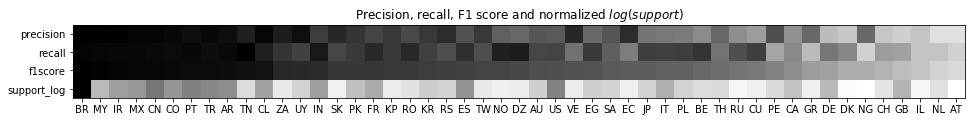

In [48]:
support_log = np.log2(prfs_df_top["support"])
prfs_image_df = prfs_df_top.assign(support_log=support_log / support_log.max()) \
                           .drop(columns=["support", "support_proportion"])
fig, ax = plt.subplots(figsize=(16, 2))
ax.grid(False)
ax.imshow(prfs_image_df.T, cmap=plt.cm.gray_r)
ax.set(
    title="Precision, recall, F1 score and normalized $log(support)$",
    xticks=range(prfs_image_df.shape[0]),
    xticklabels=prfs_image_df.index,
    yticks=range(prfs_image_df.shape[1]),
    yticklabels=prfs_image_df.columns,
);

The logarithm is applied on the support
(the squares/pixels at the bottom row)
to give some sense of the proportion.
Data is sorted by the F1 score (3rd row).

### Random forest

Let's do the same with a random forest
(several random decision trees) model,
using these weights to circumvent the data imbalance:

In [49]:
y_weights = y_train.replace(1 / y_train_counts).values

The training step for this model is $25\%$ faster,
but still takes a long time to run
(there are $4$ grid combinations,
 like the search  that have been done with the $k$-NN modeling):

In [50]:
%%time
rf_models = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=101),
    param_grid={
        "n_estimators": [10, 90],
        "criterion": ["gini", "entropy"],
    },
    cv=model_selection.StratifiedKFold(n_splits=3, 
                                       shuffle=True,
                                       random_state=209),
    return_train_score=True,
    scoring="f1_micro",
).fit(X_train, y_train, sample_weight=y_weights)

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


CPU times: user 24min 10s, sys: 1.63 s, total: 24min 12s
Wall time: 24min 16s


The best estimator is the one based on the Gini impurity criterion
with the largest number of estimators ($90$ trees).

In [51]:
rf_model = rf_models.best_estimator_
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=None,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [52]:
rf_models.cv_results_

{'mean_fit_time': array([ 12.82506084, 112.66638223,  27.70489907, 251.81643907]),
 'std_fit_time': array([ 1.12165828, 10.81511037,  1.38782006, 14.39850491]),
 'mean_score_time': array([0.13575999, 0.83298246, 0.12648463, 0.80223878]),
 'std_score_time': array([0.00941421, 0.05046572, 0.00464154, 0.06601111]),
 'param_criterion': masked_array(data=['gini', 'gini', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 90, 10, 90],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini', 'n_estimators': 10},
  {'criterion': 'gini', 'n_estimators': 90},
  {'criterion': 'entropy', 'n_estimators': 10},
  {'criterion': 'entropy', 'n_estimators': 90}],
 'split0_test_score': array([0.94757429, 0.95482935, 0.94334742, 0.94744811]),
 'split1_test_score': array([0.95086431, 0.95757614, 0.94579877, 0.9521

Here's a major difference between the models:
the prediction in the resulting random forest is
$2$ orders of magnitude faster than the $k$-NN model counterpart.

In [53]:
%%time
rf_y_pred = rf_model.predict(X_test)

CPU times: user 1.19 s, sys: 3.34 ms, total: 1.19 s
Wall time: 1.2 s


The overall accuracy is a little bit smaller
than the one we've got with $k$-NN (by $\approx 0.1\%$),
but it's still about the same,
and we don't need to worry too much about this metric.

In [54]:
metrics.accuracy_score(y_test, rf_y_pred)

0.9653017029235161

Both the micro and macro average of the F1-score
are the same in random forest and in this $k$-NN model
for the same selected entries
(countries with at least $10$ entries in the full dataset).

In [55]:
print(metrics.classification_report(y_test, rf_y_pred,
                                    labels=y_counts[y_counts >= 10].index))

              precision    recall  f1-score   support

          BR       0.97      1.00      0.98     16979
          CN       0.99      0.97      0.98       426
          PT       1.00      0.84      0.91       306
          US       0.75      0.74      0.74       297
          TR       0.97      0.91      0.94       255
          AR       0.99      0.96      0.97       207
          ES       0.92      0.67      0.78       180
          CO       0.97      0.88      0.92       162
          MX       0.95      0.95      0.95       160
          IR       0.98      0.93      0.95       124
          IN       0.92      0.87      0.90       124
          CL       0.98      0.88      0.93       111
          FR       0.93      0.75      0.83        83
          IT       0.98      0.64      0.78        73
          GB       0.72      0.29      0.41        62
          DE       0.93      0.51      0.66        53
          MY       1.00      0.98      0.99        52
          PK       0.94    

Some explanation for understanding the above results:

* The average calculation is performed with the shown values,
  other classes aren't taken into account;
* The F1 values for **SE**, **IQ**, **HR**, **AE** and **TA**
  (countries with just a few entries, $support \le 5$)
  are invalid due to a division by zero,
  but the resulting `NaN` results were replaced by zeros.
  These entries are pushing down the macro average of
  these metrics
  (the F1 macro average of the shown classes becomes $0.75$
   if we just get rid from these zeros,
   as shown in the end of this notebook);
* The precision macro average of $0.89$ is huge
  for this unbalanced data with several distinct classes,
  it means there are almost no false positives,
  no matter its class;
* We should be worried by the recall macro average of $0.59$,
  it means there are a lot of false negatives,
  i.e., several training data with a given class
  have been classified as another class,
  one with a greater support
  (else the precision wouldn't be that huge);

The full table with these metrics can be found with:

In [56]:
rf_prfs_tuple = metrics.precision_recall_fscore_support(y_test, rf_y_pred,
                                                        labels=rf_model.classes_)
rf_prfs_df = pd.DataFrame(np.array(rf_prfs_tuple).T,
                          index=rf_model.classes_.tolist(),
                          columns=["precision", "recall", "f1score", "support"]) 

Like what had been done with $k$-NN,
the rows with a support of at least $6$ elements are:

In [57]:
rf_prfs_df_top = rf_prfs_df[rf_prfs_df["support"] > 5] \
    .sort_values(["f1score", "support"], ascending=False) \
    .assign(support_proportion=lambda df: df["support"] / rf_prfs_df["support"].sum())
rf_prfs_df_top

,precision,recall,f1score,support,support_proportion
MY,1.000000,0.980769,0.990291,52.0,0.002560
BR,0.968327,0.999352,0.983595,16979.0,0.835910
CN,0.992788,0.969484,0.980998,426.0,0.020973
TN,1.000000,0.944444,0.971429,18.0,0.000886
AR,0.985075,0.956522,0.970588,207.0,0.010191
IR,0.982906,0.927419,0.954357,124.0,0.006105
MX,0.950000,0.950000,0.950000,160.0,0.007877
TR,0.974790,0.909804,0.941176,255.0,0.012554
CL,0.980000,0.882883,0.928910,111.0,0.005465
RO,1.000000,0.866667,0.928571,15.0,0.000738


And these are the values for the macro averages:

In [58]:
rf_prfs_df_top.mean()

precision               0.969332
recall                  0.666339
f1score                 0.763888
support               412.285714
support_proportion      0.020298
dtype: float64

Using this macro F1 score alone
as our metric for the resulting model,
this model is better than the $k$-NN model
we've seen before.
That precision is huge!

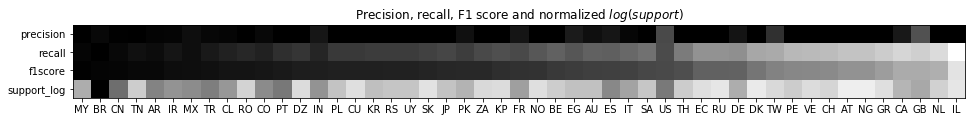

In [59]:
rf_support_log = np.log2(rf_prfs_df_top["support"])
rf_prfs_image_df = rf_prfs_df_top.assign(support_log=rf_support_log / rf_support_log.max()) \
                                 .drop(columns=["support", "support_proportion"])
fig, ax = plt.subplots(figsize=(16, 2))
ax.grid(False)
ax.imshow(rf_prfs_image_df.T, cmap=plt.cm.gray_r)
ax.set(
    title="Precision, recall, F1 score and normalized $log(support)$",
    xticks=range(rf_prfs_image_df.shape[0]),
    xticklabels=rf_prfs_image_df.index,
    yticks=range(rf_prfs_image_df.shape[1]),
    yticklabels=rf_prfs_image_df.columns,
);

Clearly, we can predict the country
based on the LSI model of the remaining fields.